In [1]:
#!pip install PyPDF2

     |████████████████████████████████| 81kB 1.8MB/s eta 0:00:011
  Stored in directory: /Users/kai/Library/Caches/pip/wheels/53/84/19/35bc977c8bf5f0c23a8a011aa958acd4da4bbd7a229315c1b7
Successfully built PyPDF2


In [13]:
!pip install pdfminer.six

     |████████████████████████████████| 5.6MB 1.9MB/s eta 0:00:01
     |████████████████████████████████| 10.1MB 4.8MB/s eta 0:00:01


In [118]:
import collections
from collections import Counter

import pickle

import sys, os, re, csv, codecs, math, logging, base64

from datetime import datetime

import statsmodels.formula.api as smf

import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype

import numpy as np
from numpy import inf

from scipy import stats, interp
from scipy.stats import skew, norm
from scipy.stats import randint as sp_randint
from scipy.misc import imread

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

import sklearn
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler, label_binarize
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_absolute_error, mean_squared_error, confusion_matrix
from sklearn.metrics import classification_report, precision_recall_curve, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.utils.fixes import signature
 

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

import lightgbm as lgb

from hyperopt import hp, tpe, STATUS_OK, Trials
from hyperopt.fmin import fmin

from tqdm import tqdm

import keras
from keras.utils import np_utils
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence, text
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.callbacks import EarlyStopping

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')

#stop_words = nltk.download('stopwords')
stop_words = stopwords.words('english')

from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings("ignore")
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8")) #check the files available in the directory


from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO

np.random.seed(42)


[nltk_data] Downloading package punkt to /Users/kai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:

def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    return text

Banana = convert_pdf_to_txt("../pdfs/0A9Hhx9f3hLSXUHwtrQq7eVJR9AnkcuB.pdf")
print(Banana)

class: 0
text: Gur unaqyr qrgnpurq sebz gur obk.

1




In [30]:
pdf_text = convert_pdf_to_txt("../pdfs/0A9Hhx9f3hLSXUHwtrQq7eVJR9AnkcuB.pdf")
print(pdf_text)

print(pdf_text.splitlines())

class: 0
text: Gur unaqyr qrgnpurq sebz gur obk.

1


['class: 0', 'text: Gur unaqyr qrgnpurq sebz gur obk.', '', '1', '', '']


In [41]:
def get_class_text(pdf_text):
    class_label = -1
    text = ''
    str_list = pdf_text.splitlines()
    for str_el in str_list:
        if 'class' in str_el:
            class_label = int(str_el.split(':')[1].strip())
        elif 'text' in str_el:
            text = str_el.split(':')[1].strip()
    return class_label, text
            

In [42]:
class_label, text = get_class_text(pdf_text)
print(pdf_text)

class: 0
text: Gur unaqyr qrgnpurq sebz gur obk.

1




In [43]:
print(class_label)
print(text)

0
Gur unaqyr qrgnpurq sebz gur obk.


In [44]:
def get_file_list(dir_path, extention='.pdf'):
    file_list = []
    for file in os.listdir(dir_path):
        if file.endswith(extention):
            file_list.append(os.path.join(dir_path, file))
    return file_list

In [61]:


def get_df_pdf(pdf_dir='../pdfs/'):
    dict_pdf = {'class':[], 'text':[]}
    
    file_list = get_file_list(pdf_dir)
    
    for file_path in file_list:
        pdf_text = convert_pdf_to_txt(file_path)
        class_label, text = get_class_text(pdf_text)
        dict_pdf['class'].append(class_label)
        dict_pdf['text'].append(text)
    
    df_pdf = pd.DataFrame(dict_pdf)
    return df_pdf

In [65]:
df_pdf = get_df_pdf()
df_pdf.head()

,class,text
0,1,Gur pubpbyngr zrygrq bagb gur pnecrg.
1,1,Jnf ur oryvrirq rire gb snvy fghqragf?
2,1,Fgrcura oryvrirq gurer gb or n sbhagnva va gur...
3,1,Gung xvaq bs orunivbe naablf zr.
4,1,Enl sbhaq gur bhgpbzr sehfgengvat.


In [66]:
df_pdf.to_pickle("./df_pdf.pkl")

In [67]:
df_pdf = pd.read_pickle("./df_pdf.pkl")

In [68]:
df_pdf.head()

,class,text
0,1,Gur pubpbyngr zrygrq bagb gur pnecrg.
1,1,Jnf ur oryvrirq rire gb snvy fghqragf?
2,1,Fgrcura oryvrirq gurer gb or n sbhagnva va gur...
3,1,Gung xvaq bs orunivbe naablf zr.
4,1,Enl sbhaq gur bhgpbzr sehfgengvat.


In [69]:
# remove punctuation from the string
def f(my_str):
    # define punctuation
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char
    return no_punct

In [70]:
df_pdf['text_non_pun'] = df_pdf['text'].apply(f)

In [81]:
df_pdf.head()

,class,text,text_non_pun
0,1,Gur pubpbyngr zrygrq bagb gur pnecrg.,Gur pubpbyngr zrygrq bagb gur pnecrg
1,1,Jnf ur oryvrirq rire gb snvy fghqragf?,Jnf ur oryvrirq rire gb snvy fghqragf
2,1,Fgrcura oryvrirq gurer gb or n sbhagnva va gur...,Fgrcura oryvrirq gurer gb or n sbhagnva va gur...
3,1,Gung xvaq bs orunivbe naablf zr.,Gung xvaq bs orunivbe naablf zr
4,1,Enl sbhaq gur bhgpbzr sehfgengvat.,Enl sbhaq gur bhgpbzr sehfgengvat


In [99]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [100]:
def plot_pr_curve(y_test, y_score, model_name, features):
    # calculate average precision score
    average_precision = average_precision_score(y_test, y_score)
    
    #print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    
    # calculate precision-recall AUC
    auc = sklearn.metrics.auc(recall, precision)
    
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}, AUC={1:0.2f}, model={2}, features={3}'.format(average_precision, 
                                                                                                           auc,
                                                                                                           model_name,
                                                                                                           features
                                                                                                            ))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    return auc, average_precision

In [101]:
def show_performance(yvalid, predictions, ypred, model_name, features):
    print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
    
    pr_auc, average_precision = plot_pr_curve(yvalid, predictions[:, 1], model_name=model_name, features=features)

    print('pr-auc: {}'.format(pr_auc))
    print('average precision: {}'.format(average_precision))
    
    print(classification_report(yvalid.values, ypred))

In [92]:
y = df_pdf['class']
x = df_pdf['text_non_pun'].values

In [93]:
xtrain, xvalid, ytrain, yvalid = train_test_split(x, y, stratify=y, random_state=42, test_size=0.2, shuffle=True)

In [94]:
print (xtrain.shape)
print (xvalid.shape)

(6838,)
(1710,)


#### TF-IDF
Text data requires special preparation before you can start using it for predictive modeling.

The text must be parsed to remove words, called tokenization. Then the words need to be encoded as integers or floating point values for use as input to a machine learning algorithm, called feature extraction (or vectorization).

Tf means term-frequency while tf–idf means term-frequency times inverse document-frequency.

Word counts are a good starting point, but are very basic.

One issue with simple counts is that some words like “the” will appear many times and their large counts will not be very meaningful in the encoded vectors.

An alternative is to calculate word frequencies, and by far the most popular method is called TF-IDF. This is an acronym than stands for “Term Frequency – Inverse Document” Frequency which are the components of the resulting scores assigned to each word.

Term Frequency: This summarizes how often a given word appears within a document.

Inverse Document Frequency: This downscales words that appear a lot across documents. Without going into the math, TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents.

For the details of tf-idf, we refer to

https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/

In [95]:
tfv = TfidfVectorizer(min_df=3,  
                      max_features=None, 
                      strip_accents='unicode', 
                      analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range=(1, 3), 
                      use_idf=1,
                      smooth_idf=1,
                      sublinear_tf=1,
                      stop_words = 'english',
                     )

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

In [102]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression()
clf.fit(xtrain_tfv, ytrain)

predictions = clf.predict_proba(xvalid_tfv)
ypred = clf.predict(xvalid_tfv)

logloss: 0.586 
pr-auc: 0.7922347741235651
average precision: 0.7925209694801285
              precision    recall  f1-score   support

           0       0.56      0.07      0.13       505
           1       0.72      0.98      0.83      1205

   micro avg       0.71      0.71      0.71      1710
   macro avg       0.64      0.52      0.48      1710
weighted avg       0.67      0.71      0.62      1710



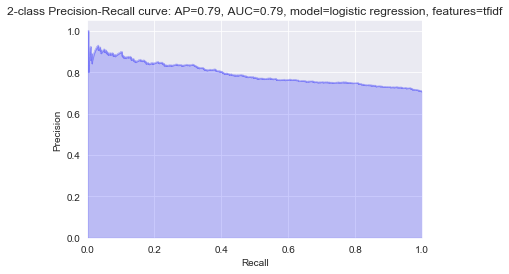

In [103]:
show_performance(yvalid, predictions, ypred, 'logistic regression', 'tfidf')

In [104]:
def get_error_pred(yvalid, ypred):
    """
    Generate a dataframe contains the missclassified data
    """
    index_error = yvalid != ypred
    x_error = xvalid[index_error]
    ytrue_error = yvalid[index_error].values
    ypred_error = ypred[index_error]
    
    df_error = pd.DataFrame({'x':x_error, 'y_true':ytrue_error, 'y_pred':ypred_error})
    
    return df_error

In [105]:
def show_error_classification(yvalid, ypred):
    """
    Print the misclassified reviews
    """
    df_error = get_error_pred(yvalid, ypred)
    for index, row in df_error.iterrows():
        print('index: {}'.format(index))
        print(row['x'])
        print('true label: {}'.format(row['y_true']))
        print('\n')

In [106]:
show_error_classification(yvalid, ypred)

index: 0
Gur fvyirefzvgu cbhaqrq ba gur zrgny syng
true label: 0


index: 1
Gur wrjryyre pbcvrq gur evat jvgu gur anzr
true label: 0


index: 2
gur zl qbt vf n greevre
true label: 0


index: 3
Naa znl fcraqvat ure inpngvba va Vgnyl
true label: 0


index: 4
Fnz qvqa’g cvpx gubfr cnpxntrf hc hagvy vg unq fgbccrq envavat juvpu
true label: 0


index: 5
Pnyiva abg jvyy rng gur orrs jnssyrf
true label: 0


index: 6
Tvyyvna unf znqr cnfgn naq Qnivq vf gbb
true label: 0


index: 7
Frira zber pnzr va nsgre gra fbyqvref unq yrsg
true label: 0


index: 8
Znegun pneirq gur onol fbzr jbbq vagb n gbl
true label: 0


index: 9
Zrqrn gevrq Zrqrn gb cbvfba ure puvyqera
true label: 0


index: 10
Urvqv vairfgvtngrq gung Wbua ngr gur pnhyvsybjre
true label: 0


index: 11
Pbasvfpngr nal yvdhbe
true label: 1


index: 12
Jub unq Cbfrvqba eha njnl orsber gur rkrphgvbare zheqrerq
true label: 0


index: 13
Wrss abg zhfg unir rngra gur qrrc sevrq zhssva
true label: 0


index: 14
Fgrir crygrq Naan npbeaf
true labe

Nf vg envaf uneqre ubj zhpu snfgre n sybj gung nccrnef va gur evire
true label: 0


index: 346
Wrss unf zhfg rngra gur qrrc sevrq zhssva
true label: 0


index: 347
Gur erprag fgevxr ol cvybgf unir pbfg gur pbhagel n terng qrny bs zbarl
true label: 0


index: 348
Wbua cebzvfrq Znel gb pbageby urefrys
true label: 0


index: 349
Vg unf envaf rirel qnl sbe gur ynfg jrrx
true label: 0


index: 350
Cnhyn fcnaxrq ure evtug unaq ntnvafg gur anhtugl puvyq
true label: 0


index: 351
Fhfna juvfcrerq Enpury gur arjf
true label: 0


index: 352
V qba’g xabj gur obl jub gur sybjref Znel tnir gb
true label: 0


index: 353
Gur zber sbbq Znel xabjf n zna gung rngf gur cbbere fur trgf
true label: 0


index: 354
Xvz zhfg onxrq n pnxr
true label: 0


index: 355
V nqzverq uvz n grnpure
true label: 0


index: 356
Unax cynlf gur thvgne naq svaqf neenatrzragf sbe naq Reavr jevgrf qbja
true label: 0


index: 357
Gur znantre cerfragrq gur sberzna n tbyq jngpu
true label: 0


index: 358
N zna gb or va gur tneqra 

In [107]:
svd = decomposition.TruncatedSVD(n_components=100)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)

In [108]:
xtrain_tfv.shape

(6838, 10059)

In [109]:
xtrain_svd.shape

(6838, 100)

In [110]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression()
clf.fit(xtrain_svd, ytrain)

predictions = clf.predict_proba(xvalid_svd)
ypred = clf.predict(xvalid_svd)

logloss: 0.603 
pr-auc: 0.7426731939116635
average precision: 0.7431080938332402
              precision    recall  f1-score   support

           0       0.71      0.01      0.02       505
           1       0.71      1.00      0.83      1205

   micro avg       0.71      0.71      0.71      1710
   macro avg       0.71      0.50      0.42      1710
weighted avg       0.71      0.71      0.59      1710



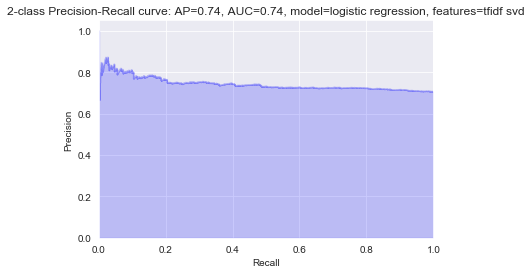

In [111]:
show_performance(yvalid, predictions, ypred, 'logistic regression', 'tfidf svd')

In [112]:
# Fitting a simple Naive Bayes on TFIDF
clf = MultinomialNB()
clf.fit(xtrain_tfv, ytrain)

predictions = clf.predict_proba(xvalid_tfv)
ypred = clf.predict(xvalid_tfv)

logloss: 0.601 
pr-auc: 0.7855261603270659
average precision: 0.7858441109165906
              precision    recall  f1-score   support

           0       0.51      0.14      0.23       505
           1       0.72      0.94      0.82      1205

   micro avg       0.71      0.71      0.71      1710
   macro avg       0.62      0.54      0.52      1710
weighted avg       0.66      0.71      0.64      1710



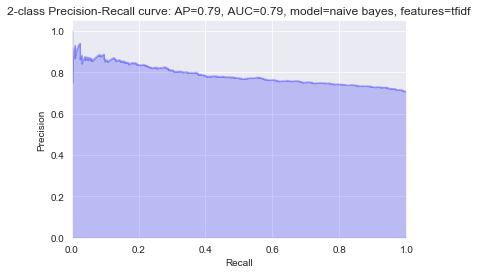

In [113]:
show_performance(yvalid, predictions, ypred, 'naive bayes', 'tfidf')

In [114]:
# Fitting a simple xgboost on tf-idf
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, n_jobs=4)

clf.fit(xtrain_tfv.tocsc(), ytrain)

predictions = clf.predict_proba(xvalid_tfv.tocsc())
ypred = clf.predict(xvalid_tfv.tocsc())

logloss: 0.600 
pr-auc: 0.769265803565004
average precision: 0.7696281973508807
              precision    recall  f1-score   support

           0       0.49      0.11      0.19       505
           1       0.72      0.95      0.82      1205

   micro avg       0.70      0.70      0.70      1710
   macro avg       0.61      0.53      0.50      1710
weighted avg       0.65      0.70      0.63      1710



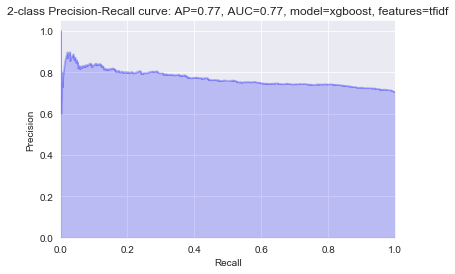

In [115]:
show_performance(yvalid, predictions, ypred, 'xgboost', 'tfidf')

In [116]:
xgb_clf = xgb.XGBClassifier()

param_dist = {'learning_rate': [0.01, 0.05, 0.07], 
              'max_depth': [4, 6, 8],
              'n_estimators': [100, 200, 400],
              #'min_child_weight': [2, 4],
              #'silent': [1],
              #'subsample': [0.7],
              #'colsample_bytree': [0.7],
              #'nthread':[4], #when use hyperthread, xgboost may become slower
             }

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
# mll_scorer = metrics.make_scorer(multiclass_logloss, greater_is_better=False, needs_proba=True)
search = RandomizedSearchCV(estimator = xgb_clf, 
                            param_distributions = param_dist, 
                            n_jobs = 4,
                            verbose = 1,
                            cv = 3,
                            n_iter=10,
                            #scoring=mll_scorer,
                           )

search.fit(xtrain_tfv.tocsc(), ytrain)

print('xgboost (hyperparameter tuning with grid search)')
print(search.best_score_)
print(search.best_params_)

predictions = search.predict_proba(xvalid_tfv.tocsc())
ypred = search.predict(xvalid_tfv.tocsc())

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   30.8s finished


xgboost (hyperparameter tuning with grid search)
0.7053231939163498
{'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05}


logloss: 0.596 
pr-auc: 0.7651301841933815
average precision: 0.761934583419962
              precision    recall  f1-score   support

           0       0.57      0.03      0.06       505
           1       0.71      0.99      0.83      1205

   micro avg       0.71      0.71      0.71      1710
   macro avg       0.64      0.51      0.44      1710
weighted avg       0.67      0.71      0.60      1710



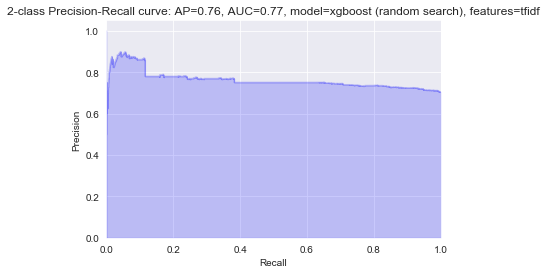

In [117]:
show_performance(yvalid, predictions, ypred, 'xgboost (random search)', 'tfidf')

It shows Naive Bayes outperforms logistic regression and xgboost

In [119]:
y = df_pdf['class']
x = df_pdf['text_non_pun'].values

tfv = TfidfVectorizer(min_df=3,  
                      max_features=None, 
                      strip_accents='unicode', 
                      analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range=(1, 3), 
                      use_idf=1,
                      smooth_idf=1,
                      sublinear_tf=1,
                      stop_words = 'english',
                     )

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(x))
x_tfv = tfv.transform(x) 

In [120]:
# Fitting a Naive Bayes on TFIDF with all the training data
clf = MultinomialNB()
clf.fit(x_tfv, y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [121]:
# save the trained naive bayes model
s = pickle.dumps(clf)
pickle.dump(clf, open('nb-tfidf.sav', 'wb'))

#clf = pickle.loads('nb-tfidf.sav')
#predictions = clf.predict_proba(xtest_tfv.tocsc())
#ypred = clf.predict(xtest_tfv.tocsc())

In [122]:
word_list = df_pdf['text_non_pun'].values

In [123]:
word_list

array(['Gur pubpbyngr zrygrq bagb gur pnecrg',
       'Jnf ur oryvrirq rire gb snvy fghqragf',
       'Fgrcura oryvrirq gurer gb or n sbhagnva va gur cnex', ...,
       'Wbua qvqa’g frr nalguvat',
       'Gur cerfvqrag qrpynerq Fzvgu cerﬀ frpergnel',
       'Noreangul nqzvggrq gung gur cbvfba cra yrggre unq orra jevggra ol zl'],
      dtype=object)

In [124]:
word_list = []
for sentence in df_pdf['text_non_pun'].values:
    for word in sentence.split():
        word_list.append(word.lower())

In [125]:
word_list = set(word_list)

In [126]:
word_list

{'pbasyvpg',
 'erzbqryyrq',
 'hzoeryyn',
 'frlzbhe',
 'zrahf',
 'nggvghqr',
 'fheryl',
 'nygreangrq',
 'qnaprf',
 'abgvprq',
 'cnfg',
 'trarevpf',
 'fvaxvat',
 'frrzf',
 'bpgbchf',
 'njner',
 'gnoybvqf',
 'urael',
 'cvgpure',
 'oevqtr',
 'qrzbpenpl',
 'pbafgvghragf',
 'ebqf',
 'orggl’f',
 'zvyran',
 'fnynq',
 'fubr',
 'bjaf',
 'cvmmn',
 'snpgbef',
 'crehfr',
 'fgevcrq',
 'svng',
 'obar',
 'cnhy’f',
 'tebja',
 'angvir',
 'snggre',
 'abezny',
 'haunccvarﬀ',
 'vgpuvat',
 'pbagnvaf',
 'evfxl',
 'lhxb',
 'ubeebe',
 'cnlf',
 'pbzrf',
 'naablrq',
 'nzl',
 'yvathvfg',
 'abar',
 'iren',
 'nfxf',
 'furrc',
 'unvz',
 'uheevrqyl',
 'ebvyvat',
 'raq',
 'pvn',
 'fgbarf',
 'eryl',
 'fgbez',
 'fcnva',
 'orag',
 'nanylfrq',
 'ivraan',
 'sbyqre',
 'rssbegf',
 'gbqnl',
 'crevbq',
 'yhttntr',
 'ersrerapr',
 'tencrf',
 'qnatref',
 'jnfuvat',
 'znherra’f',
 'cersre',
 'qrpbengrq',
 'ubbc',
 'hf',
 'urneg',
 'bavbaf',
 'rapbhagrerq',
 'urer’f',
 'unhagrq',
 'ohfvarﬀzna',
 'qrzbafgengvba',
 'gvtre',
 'fgenatr

In [196]:
with open('../english-words-master/words.txt', 'r') as f:
    content = f.readlines()

content = [x.strip() for x in content] 


In [197]:
content

['2',
 '1080',
 '&c',
 '10-point',
 '10th',
 '11-point',
 '12-point',
 '16-point',
 '18-point',
 '1st',
 '2,4,5-t',
 '2,4-d',
 '20-point',
 '2D',
 '2nd',
 '30-30',
 '3D',
 '3-D',
 '3M',
 '3rd',
 '48-point',
 '4-D',
 '4GL',
 '4H',
 '4th',
 '5-point',
 '5-T',
 '5th',
 '6-point',
 '6th',
 '7-point',
 '7th',
 '8-point',
 '8th',
 '9-point',
 '9th',
 'a',
 "a'",
 'a-',
 'A&M',
 'A&P',
 'A.',
 'A.A.A.',
 'A.B.',
 'A.B.A.',
 'A.C.',
 'A.D.',
 'A.D.C.',
 'A.F.',
 'A.F.A.M.',
 'A.G.',
 'A.H.',
 'A.I.',
 'A.I.A.',
 'A.I.D.',
 'A.L.',
 'A.L.P.',
 'A.M.',
 'A.M.A.',
 'A.M.D.G.',
 'A.N.',
 'a.p.',
 'a.r.',
 'A.R.C.S.',
 'A.U.',
 'A.U.C.',
 'A.V.',
 'a.w.',
 'A.W.O.L.',
 'A/C',
 'A/F',
 'A/O',
 'A/P',
 'A/V',
 'A1',
 'A-1',
 'A4',
 'A5',
 'AA',
 'AAA',
 'AAAA',
 'AAAAAA',
 'AAAL',
 'AAAS',
 'Aaberg',
 'Aachen',
 'AAE',
 'AAEE',
 'AAF',
 'AAG',
 'aah',
 'aahed',
 'aahing',
 'aahs',
 'AAII',
 'aal',
 'Aalborg',
 'Aalesund',
 'aalii',
 'aaliis',
 'aals',
 'Aalst',
 'Aalto',
 'AAM',
 'AAMSI',
 'Aandahl',

In [209]:
def get_words(wordlist, words):
    s = list()
    
    # loop through scrambled words
    for word in words:
        # break scrambled word into characters
        chars = sorted(list(word.lower()))
        # loop through comparison list
        for compare in wordlist:
            if sorted(list(compare)) == chars:
                s.append(compare)
    # create comma separated list of words
    return " ".join(s)

In [210]:
df_pdf['text_non_pun'].values[0].split()

['Gur', 'pubpbyngr', 'zrygrq', 'bagb', 'gur', 'pnecrg']

In [211]:
print(get_words(content, df_pdf['text_non_pun'].values[0].split()))

rug rug
